# Monitorización de equipos industriales para detección de fallos


### 1. Importación de librerias

In [241]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import resample
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from keras.callbacks import EarlyStopping
from keras_tuner import RandomSearch

### 2. Carga del csv

In [242]:
df = pd.read_csv("equipment_anomaly_data.csv")
df.head()

,temperature,pressure,vibration,humidity,equipment,location,faulty
0,58.180180,25.029278,0.606516,45.694907,Turbine,Atlanta,0.0
1,75.740712,22.954018,2.338095,41.867407,Compressor,Chicago,0.0
2,71.358594,27.276830,1.389198,58.954409,Turbine,San Francisco,0.0
3,71.616985,32.242921,1.770690,40.565138,Pump,Atlanta,0.0
4,66.506832,45.197471,0.345398,43.253795,Pump,New York,0.0


### 3. Detección de anomalías

In [243]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7672 entries, 0 to 7671
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  7672 non-null   float64
 1   pressure     7672 non-null   float64
 2   vibration    7672 non-null   float64
 3   humidity     7672 non-null   float64
 4   equipment    7672 non-null   object 
 5   location     7672 non-null   object 
 6   faulty       7672 non-null   float64
dtypes: float64(5), object(2)
memory usage: 419.7+ KB


In [244]:
df.describe()

,temperature,pressure,vibration,humidity,faulty
count,7672.000000,7672.000000,7672.000000,7672.000000,7672.000000
mean,70.922478,35.738048,1.611809,50.016574,0.099974
std,16.200059,10.381593,0.728560,11.841479,0.299985
min,10.269385,3.620798,-0.428188,10.215077,0.000000
25%,62.777057,29.485682,1.170906,42.612817,0.000000
50%,70.156900,35.227544,1.533113,50.024744,0.000000
75%,77.568387,41.159913,1.924700,57.340513,0.000000
max,149.690420,79.887734,4.990537,89.984718,1.000000


In [245]:
df.isnull().sum()

temperature    0
pressure       0
vibration      0
humidity       0
equipment      0
location       0
faulty         0
dtype: int64

In [246]:
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
7667    False
7668    False
7669    False
7670    False
7671    False
Length: 7672, dtype: bool

In [247]:
df.columns

Index(['temperature', 'pressure', 'vibration', 'humidity', 'equipment',
       'location', 'faulty'],
      dtype='object')

### 4. Visualización de datos

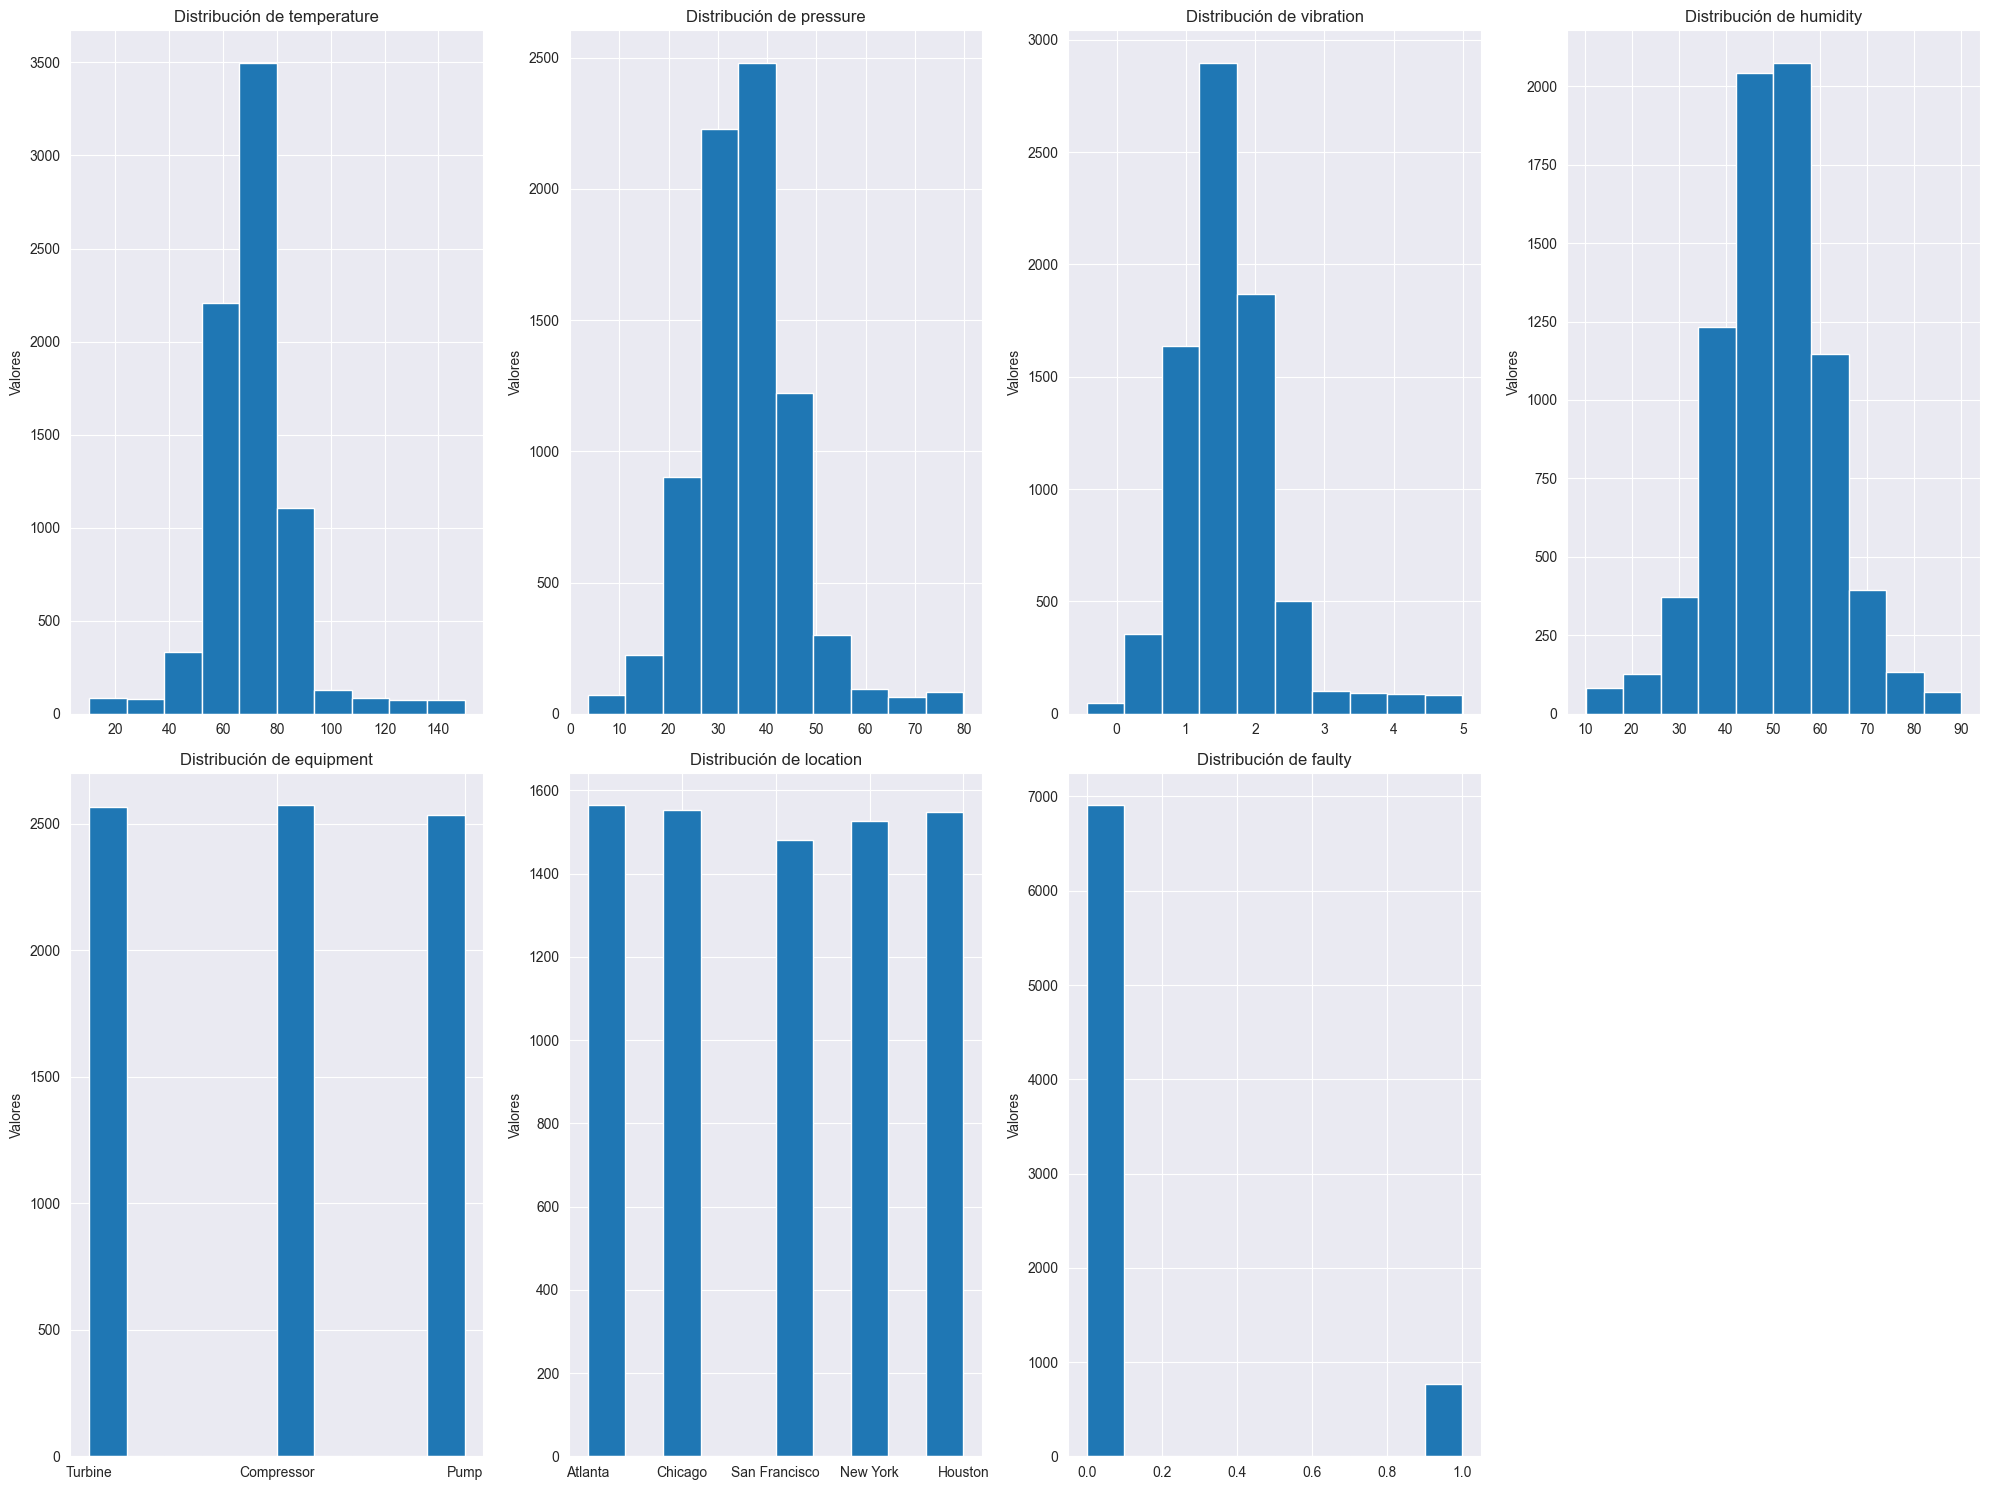

In [248]:
categorias = ['temperature', 'pressure', 'vibration', 'humidity', 'equipment','location', 'faulty']
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 15))
axes = axes.flatten()
for i, var in enumerate(categorias):
 axes[i].hist(df[var])
 axes[i].set_title(f'Distribución de {var}')
 axes[i].set_ylabel('Valores')
for j in range(len(categorias), len(axes)):
 axes[j].axis('off')
plt.tight_layout()
plt.show()

In [249]:
df['equipment'].value_counts()

equipment
Compressor    2573
Turbine       2565
Pump          2534
Name: count, dtype: int64

In [250]:
df['location'].value_counts()

location
Atlanta          1564
Chicago          1553
Houston          1548
New York         1526
San Francisco    1481
Name: count, dtype: int64

In [251]:
df['faulty'].value_counts()

faulty
0.0    6905
1.0     767
Name: count, dtype: int64

De acuerdo con la ingeniería de características realizaremos `OneHotEncoder` para `equipment` y para `location`, en el caso de `faulty` necesitaremos realizar resample porque hay demasiados defectuosos en comparación con los que no

### 5. Ingeniería de características

In [252]:
# Instanciar OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)  # Crea un array en vez de una matriz

# Aplicar el encoder a las columnas categóricas
categoricas = ['location', 'equipment']
valores = encoder.fit_transform(df[categoricas])

# Crear un DataFrame con los valores codificados
columnas_codificadas = encoder.get_feature_names_out(categoricas)
df_codificado = pd.DataFrame(valores, columns=columnas_codificadas, index=df.index)

# Concatenar el DataFrame original con las columnas codificadas
df = pd.concat([df.drop(columns=categoricas, axis=1), df_codificado], axis=1)

In [253]:
df.head()

,temperature,pressure,vibration,humidity,faulty,location_Atlanta,location_Chicago,location_Houston,location_New York,location_San Francisco,equipment_Compressor,equipment_Pump,equipment_Turbine
0,58.180180,25.029278,0.606516,45.694907,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,75.740712,22.954018,2.338095,41.867407,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,71.358594,27.276830,1.389198,58.954409,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,71.616985,32.242921,1.770690,40.565138,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,66.506832,45.197471,0.345398,43.253795,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [254]:
df.shape

(7672, 13)

In [255]:
# Nos interesan los cuartiles del 25% y 75%
categorias = ['temperature', 'pressure', 'vibration', 'humidity']
Q1, Q3 = np.percentile(df['temperature'], [25, 75])
IQR = Q3 - Q1
outliers = []
for elemento in df['temperature']:
 if elemento < (Q1 - 1.5 * IQR) or elemento > (Q3 + 1.5 * IQR):
  outliers.append(elemento)
outliers

[148.92336873207364,
 141.26030984408388,
 117.25565678109554,
 135.30440061610966,
 15.905622342629414,
 128.68673398905372,
 140.48797277487645,
 120.85588955758838,
 107.20136172814424,
 36.4810056497079,
 27.75880600254094,
 13.709622907778318,
 22.27105033128577,
 112.99665489609612,
 112.78221826032777,
 117.16076125764364,
 131.4206923961483,
 112.53463791732108,
 104.47639731695436,
 18.534630261591687,
 101.7041972819861,
 118.4449549882954,
 136.8441449184553,
 124.35863656211068,
 106.78920406471175,
 31.52955881688417,
 140.19472568890708,
 23.52007189650115,
 128.13233589409057,
 101.52056734512084,
 140.37751130333112,
 102.40459182955844,
 116.23211880227356,
 27.682863992377364,
 13.901767992593836,
 19.051816782081705,
 122.98582559343484,
 10.269384763629008,
 119.3380767698758,
 31.693294968942507,
 107.19327107538489,
 27.982235905864098,
 26.30352974215728,
 139.173253137236,
 118.92352772663445,
 129.64868196136376,
 13.135595267101037,
 104.20559894906675,
 32.32

In [256]:
df = df[~df['temperature'].isin(outliers)]
df.shape

(7210, 13)

In [257]:
Q1, Q3 = np.percentile(df['pressure'], [25, 75])
IQR = Q3 - Q1
outliers2 = []
for elemento in df['pressure']:
 if elemento < (Q1 - 1.5 * IQR) or elemento > (Q3 + 1.5 * IQR):
  outliers2.append(elemento)
outliers2

[76.42672868018283,
 71.43726309539058,
 59.941449033664384,
 5.493077668572447,
 10.3395025988541,
 73.83952421176137,
 10.589222053030207,
 12.861396619180816,
 74.17327869750751,
 60.47967682546257,
 72.91471241010778,
 3.620797987053262,
 71.83406719021843,
 57.95690047930479,
 58.5619703194808,
 12.626490624249769,
 62.27868481485161,
 71.65147459752612,
 12.600285579251311,
 58.54438668214897,
 68.85194255863559,
 65.14321024815872,
 65.69045396124903,
 79.61094544808543,
 77.40758080781703,
 4.306755612325045,
 63.75832327134907,
 60.49259929448844,
 58.81572955218089,
 64.47621584369136,
 11.265975450074157,
 79.03323757921231,
 10.85154583545766,
 11.050347178715018,
 65.96335548746458,
 9.891882670127682,
 5.347563945414741,
 69.09636889942959,
 57.593763411161625,
 7.995367198579199,
 11.40030658658602,
 76.75386798351025,
 64.36222044670572,
 59.32549563327552,
 77.56801584901021,
 60.50617860914148,
 63.34091834820055,
 72.40779970998682,
 61.30208949910991,
 76.4821368569

In [258]:
df = df[~df['pressure'].isin(outliers2)]
df.shape

(7044, 13)

In [259]:
Q1, Q3 = np.percentile(df['vibration'], [25, 75])
IQR = Q3 - Q1
outliers2 = []
for elemento in df['vibration']:
 if elemento < (Q1 - 1.5 * IQR) or elemento > (Q3 + 1.5 * IQR):
  outliers2.append(elemento)
outliers2

[3.923827587070224,
 0.0230882572996877,
 0.0064168161469013,
 3.965478665378277,
 3.408486964599446,
 3.2070975654212046,
 2.9370413490049567,
 3.275657845639828,
 0.0529074712142081,
 -0.1679507747345481,
 3.4996302898155878,
 -0.0052612581567583,
 3.97513097059836,
 0.0440980276413671,
 -0.317600113770051,
 3.471165505403343,
 0.0318995281109424,
 4.626760432425203,
 3.779432869883537,
 3.2606224331002926,
 4.799801758523439,
 4.432625316166088,
 3.4240049939375923,
 3.7711604577913738,
 3.035668350803001,
 4.65657563324011,
 4.116261787075627,
 3.475104776597145,
 -0.0471446245456947,
 3.6073148500956913,
 -0.0996323226060891,
 2.969094033577885,
 0.0023665546001918,
 4.289965396784703,
 3.81008136355764,
 -0.1539499762486942,
 3.632169131935889,
 4.430816513358485,
 2.9453214951995688,
 3.640224649121755,
 -0.1251667380978529,
 0.0119837629952377,
 4.17968465650718,
 4.004312342788758,
 4.757150226856697,
 3.850984380246559,
 4.65530174744451,
 3.436587241946445,
 4.49762763769304

In [260]:
df = df[~df['vibration'].isin(outliers2)]
df.shape

(6913, 13)

In [261]:
Q1, Q3 = np.percentile(df['humidity'], [25, 75])
IQR = Q3 - Q1
outliers2 = []
for elemento in df['humidity']:
 if elemento < (Q1 - 1.5 * IQR) or elemento > (Q3 + 1.5 * IQR):
  outliers2.append(elemento)
outliers2

[81.58941784588663,
 12.909713420227416,
 79.42752646005437,
 84.47879012070042,
 19.906588573168264,
 84.39381886783303,
 20.347894701146597,
 77.64348516117136,
 82.15374196212832,
 18.15045574821545,
 19.446820536804896,
 17.044388200326914,
 78.67106817187974,
 20.09398551795464,
 20.932259512041853,
 81.32326150808461,
 22.248115388918976,
 13.67995714479095,
 12.62312120638681,
 82.53787602449997,
 15.049547775113943,
 21.84189505522706,
 13.746248696875403,
 21.912754076423365,
 13.44913484895894,
 18.36242993418722,
 86.689913156033,
 81.36686048322272,
 79.61283696951351,
 77.92385761315072,
 14.075896928236649,
 79.3793191215934,
 21.1798663683197,
 13.8883592662601,
 85.27368956188823,
 22.1271107464422,
 12.885865127700049,
 78.1756049976551,
 21.514729113483934,
 13.681095421872316,
 19.442910508557997,
 20.58371528236237,
 17.956249782063082,
 79.98734105502464,
 14.105238788890864,
 19.5984072775879,
 88.21288188267445,
 79.33605706171272,
 17.317102408796224,
 80.382816

In [262]:
df = df[~df['humidity'].isin(outliers2)]
df.shape

(6853, 13)

Aplicando el rango intercuartílico hemos eliminado los outliers de las variables numericas, pero si recordamos la visaulización del prinicpio hemos visto que la variable objetivo tiene muchos datos de la clase 0 y muy pocos de la 1, vamos a reajustar este inconveniente

In [263]:
# Supongamos que separamos clases mayoritaria y minoritaria
df_major = df[df['faulty'] == 0]
df_minor = df[df['faulty'] == 1]
# Ahora hacemos oversampling de la clase minoritaria
df_minor_oversampled = resample(df_minor,
replace=True,n_samples=len(df_major), random_state=42)
# Combinar las clases
df_balanced = pd.concat([df_major, df_minor_oversampled])

(array([6767.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        6767.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

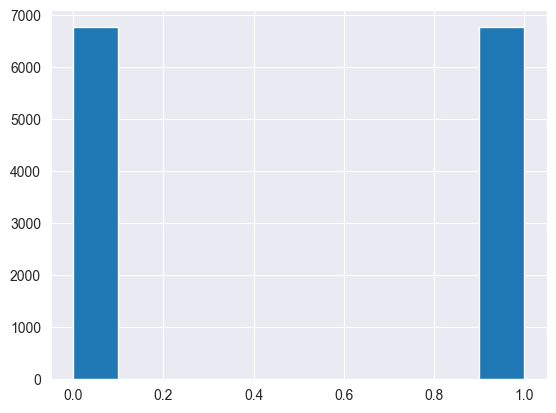

In [264]:
plt.hist(df_balanced['faulty'])

In [265]:
X = df.drop('faulty',axis=1)
y = df['faulty']
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [266]:
# Creamos el modelo de red neuronal
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model = Sequential([
 Input(shape=(X_train.shape[1],)), # Definir forma de la entrada
    Dense(32, activation='relu'), # 1a capa oculta
    Dropout(0.5),
    Dense(16, activation='relu'), # 1a capa oculta
    Dropout(0.3),
    Dense(8, activation='relu'), # 2a capa oculta
    Dense(1, activation='sigmoid') # Salida
])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
# Mostramos configuración
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_42 (Dense)                │ (None, 32)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,089 (4.25 KB)

 Trainable params: 1,089 (4.25 KB)

 Non-trainable params: 0 (0.00 B)

In [267]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7262 - loss: 0.5381 - val_accuracy: 0.9891 - val_loss: 0.0844
Epoch 2/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9875 - loss: 0.1173 - val_accuracy: 0.9891 - val_loss: 0.0712
Epoch 3/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9860 - loss: 0.0963 - val_accuracy: 0.9891 - val_loss: 0.0707
Epoch 4/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9859 - loss: 0.1009 - val_accuracy: 0.9891 - val_loss: 0.0690
Epoch 5/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9876 - loss: 0.0865 - val_accuracy: 0.9891 - val_loss: 0.0673
Epoch 6/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9883 - loss: 0.0766 - val_accuracy: 0.9891 - val_loss: 0.0655
Epoch 7/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9855 - loss: 0.0906 - val_accuracy: 0.9891 - val_loss: 0.0655
Epoch 8/50
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9888 - loss: 0.0760 - val_accuracy: 0.

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9902 - loss: 0.0559
Pérdida: 0.07477772980928421, Precisión: 0.9861415028572083


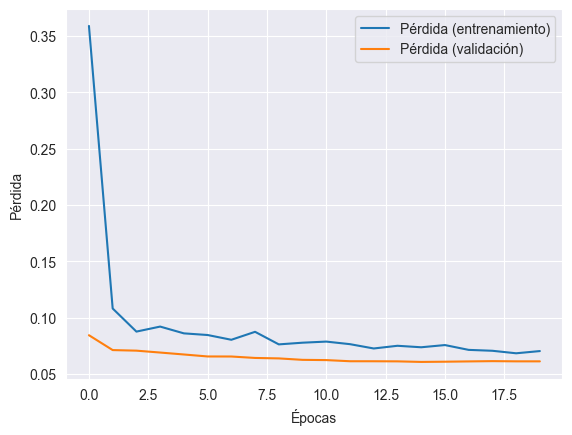

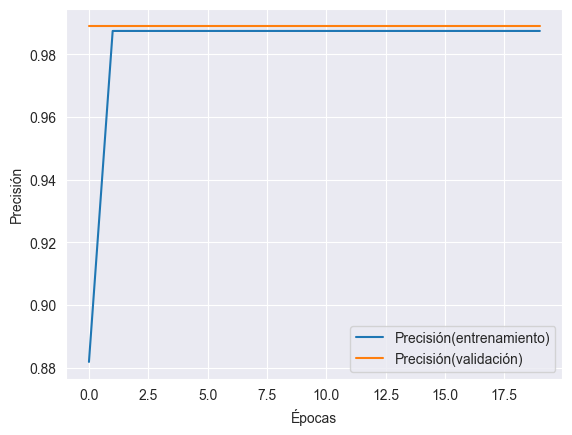

In [268]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Pérdida: {loss}, Precisión: {accuracy}")
# Pérdida
plt.plot(history.history['loss'], label='Pérdida (entrenamiento)')
plt.plot(history.history['val_loss'], label='Pérdida (validación)')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()
# Precisión
plt.plot(history.history['accuracy'], label='Precisión(entrenamiento)')
plt.plot(history.history['val_accuracy'], label='Precisión(validación)')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Reporte de Clasificación:
                  precision    recall  f1-score   support

No Mantenimiento       0.99      1.00      0.99      1352
   Mantenimiento       0.00      0.00      0.00        19

        accuracy                           0.99      1371
       macro avg       0.49      0.50      0.50      1371
    weighted avg       0.97      0.99      0.98      1371



C:\Users\ESP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ESP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ESP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

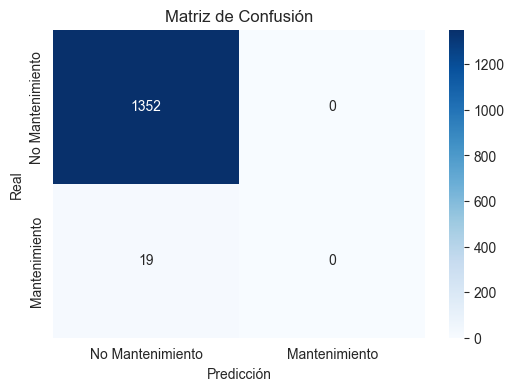

In [269]:
def train_validation(model, X_test, y_test):
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convertir probabilidades en etiquetas binarias

    # Matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Reporte de clasificación
    print("\nReporte de Clasificación:")
    print(classification_report(y_test, y_pred, target_names=["No Mantenimiento", "Mantenimiento"]))

    # Mostrar matriz de confusión con heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=["No Mantenimiento", "Mantenimiento"],
                yticklabels=["No Mantenimiento", "Mantenimiento"])
    plt.title("Matriz de Confusión")
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.show()

# Llama a la función con el modelo ya entrenado
train_validation(model, X_test, y_test)

In [270]:
from keras_tuner.src.backend.io import tf

def build_model(hp):
 model = Sequential([Dense(units=hp.Int('units', min_value=32, max_value=512,step=32), activation='relu'),
 Dense(1)
 ])
 model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = hp.Choice('learning_rate', [0.001, 0.01])),loss = 'mean_squared_error', metrics = ['mae'])
 return model

tuner = RandomSearch(
 build_model,
 objective='val_loss',
 max_trials=5,
 directory='nuevo_modelo',
 project_name='hiperparametros'
)
tuner.search(X_train, y_train, epochs=10, validation_split=0.2)

FailedPreconditionError: nuevo_modelo\hiperparametros is not a directory

In [ ]:
# Llama a la función con el modelo ya entrenado
train_validation(model, X_test, y_test)